# Using `ArviZ` for Plotting and Chain Statistics

I wrote up a short example for using `ArviZ` to examine MCMC chains. The plotting is fairly nice, but the main usefulness I think comes with the different convergence and diagnostic tests. Most of the tests need multiple chains to work, so keep that in mind. There are also way more options than I put here, but this is just a start!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os
import numpy as np
import arviz as az
import la_forge.core as co

import warnings
warnings.filterwarnings('ignore')

# J2317+1439 5-yr Example

In [3]:
chaindir_J2317_tm_run_1 = os.getcwd()+'/chains/J2317+1439_red_var_white_var_1'
tmparam_list_J2317 = [r'327G_ASP Efac', '327G_ASP $\mathrm{log}_{10}$Ecorr',
                        '327G_ASP $\mathrm{log}_{10}$Equad', '430G_ASP Efac',
                        '430G_ASP $\mathrm{log}_{10}$Ecorr', '430G_ASP $\mathrm{log}_{10}$Equad',
                        'Red Noise Gamma','Red Noise $\mathrm{log}_{10}$A',
                        'PB', 'A1', 'EPS1', 'EPS2',
                        'lnlike','lnprior', 'chain accept', 'pt chain accept']

In [4]:
psr_J2317_tm_run_1 = co.Core(label='psr_J2317_tm_run_1',
                             chaindir=chaindir_J2317_tm_run_1,
                             fancy_par_names=tmparam_list_J2317)

Appending PTMCMCSampler sampling parameters to end of parameter list.
If unwanted please provide a parameter list.
No burn specified. Burn set to 25% of chain length, 2475
You may change the burn length with core.set_burn()
Red noise frequencies must be set before plotting most red noise figures.
Please use core.set_rn_freqs() to set, if needed.


To give the chains and their corresponding parameters to `ArviZ`, I found that the easiest way is to associate each chain/posterior with the name of the parameter. So I use the same parameters as in `la_forge`'s `fancy_par_names` as the dict keys, then use `get_param` to pull out the corresponding chain and assign them as the dict values. To convert to the `ArviZ` format, you can just call `az.convert_to_inference_data` on the created dictionary.

In [5]:
data_dict_J2317_tm_run_1 = {}
for param, param_name in zip(psr_J2317_tm_run_1.params,tmparam_list_J2317):
    data_dict_J2317_tm_run_1[param_name] = psr_J2317_tm_run_1.get_param(param)
    
az_J2317 = az.convert_to_inference_data(data_dict_J2317_tm_run_1)

To see the summary of each parameters' chain, you can call `az.summary`. To select particular parameters you just pick out the `var_names` that correspond to the dictionary keys.

The less obvious columns correspond to:
* `hpd`:  highest posterior density (HPD) of array for given credible_interval

In [6]:
az.summary(az_J2317,var_names=tmparam_list_J2317[:-2],kind='stats')

mean     sd    hpd_3%   hpd_97%
327G_ASP Efac                         1.040  0.102     0.853     1.229
327G_ASP $\mathrm{log}_{10}$Ecorr    -6.509  0.353    -6.947    -6.121
327G_ASP $\mathrm{log}_{10}$Equad    -6.460  0.089    -6.615    -6.311
430G_ASP Efac                         1.552  0.086     1.402     1.715
430G_ASP $\mathrm{log}_{10}$Ecorr    -6.239  0.093    -6.409    -6.071
430G_ASP $\mathrm{log}_{10}$Equad    -7.573  0.505    -8.461    -6.794
Red Noise Gamma                       3.189  0.651     2.065     4.464
Red Noise $\mathrm{log}_{10}$A      -12.334  0.078   -12.474   -12.173
PB                                    0.076  0.140    -0.180     0.350
A1                                   -0.250  0.152    -0.523     0.046
EPS1                                 -0.294  0.229    -0.722     0.133
EPS2                                 -0.083  0.169    -0.405     0.216
lnlike                             6142.180  2.493  6137.560  6146.477
lnprior                            6164.024  2.490  6159.403  6168.313

`plot_trace` give the distribution and the traceplot all in nice subplots.
If you have multiple of the same runs, `plot_trace` will overplot the two. Plus, with multiple "identical" runs, `ArviZ` can start running diagnostics on the the two chains.

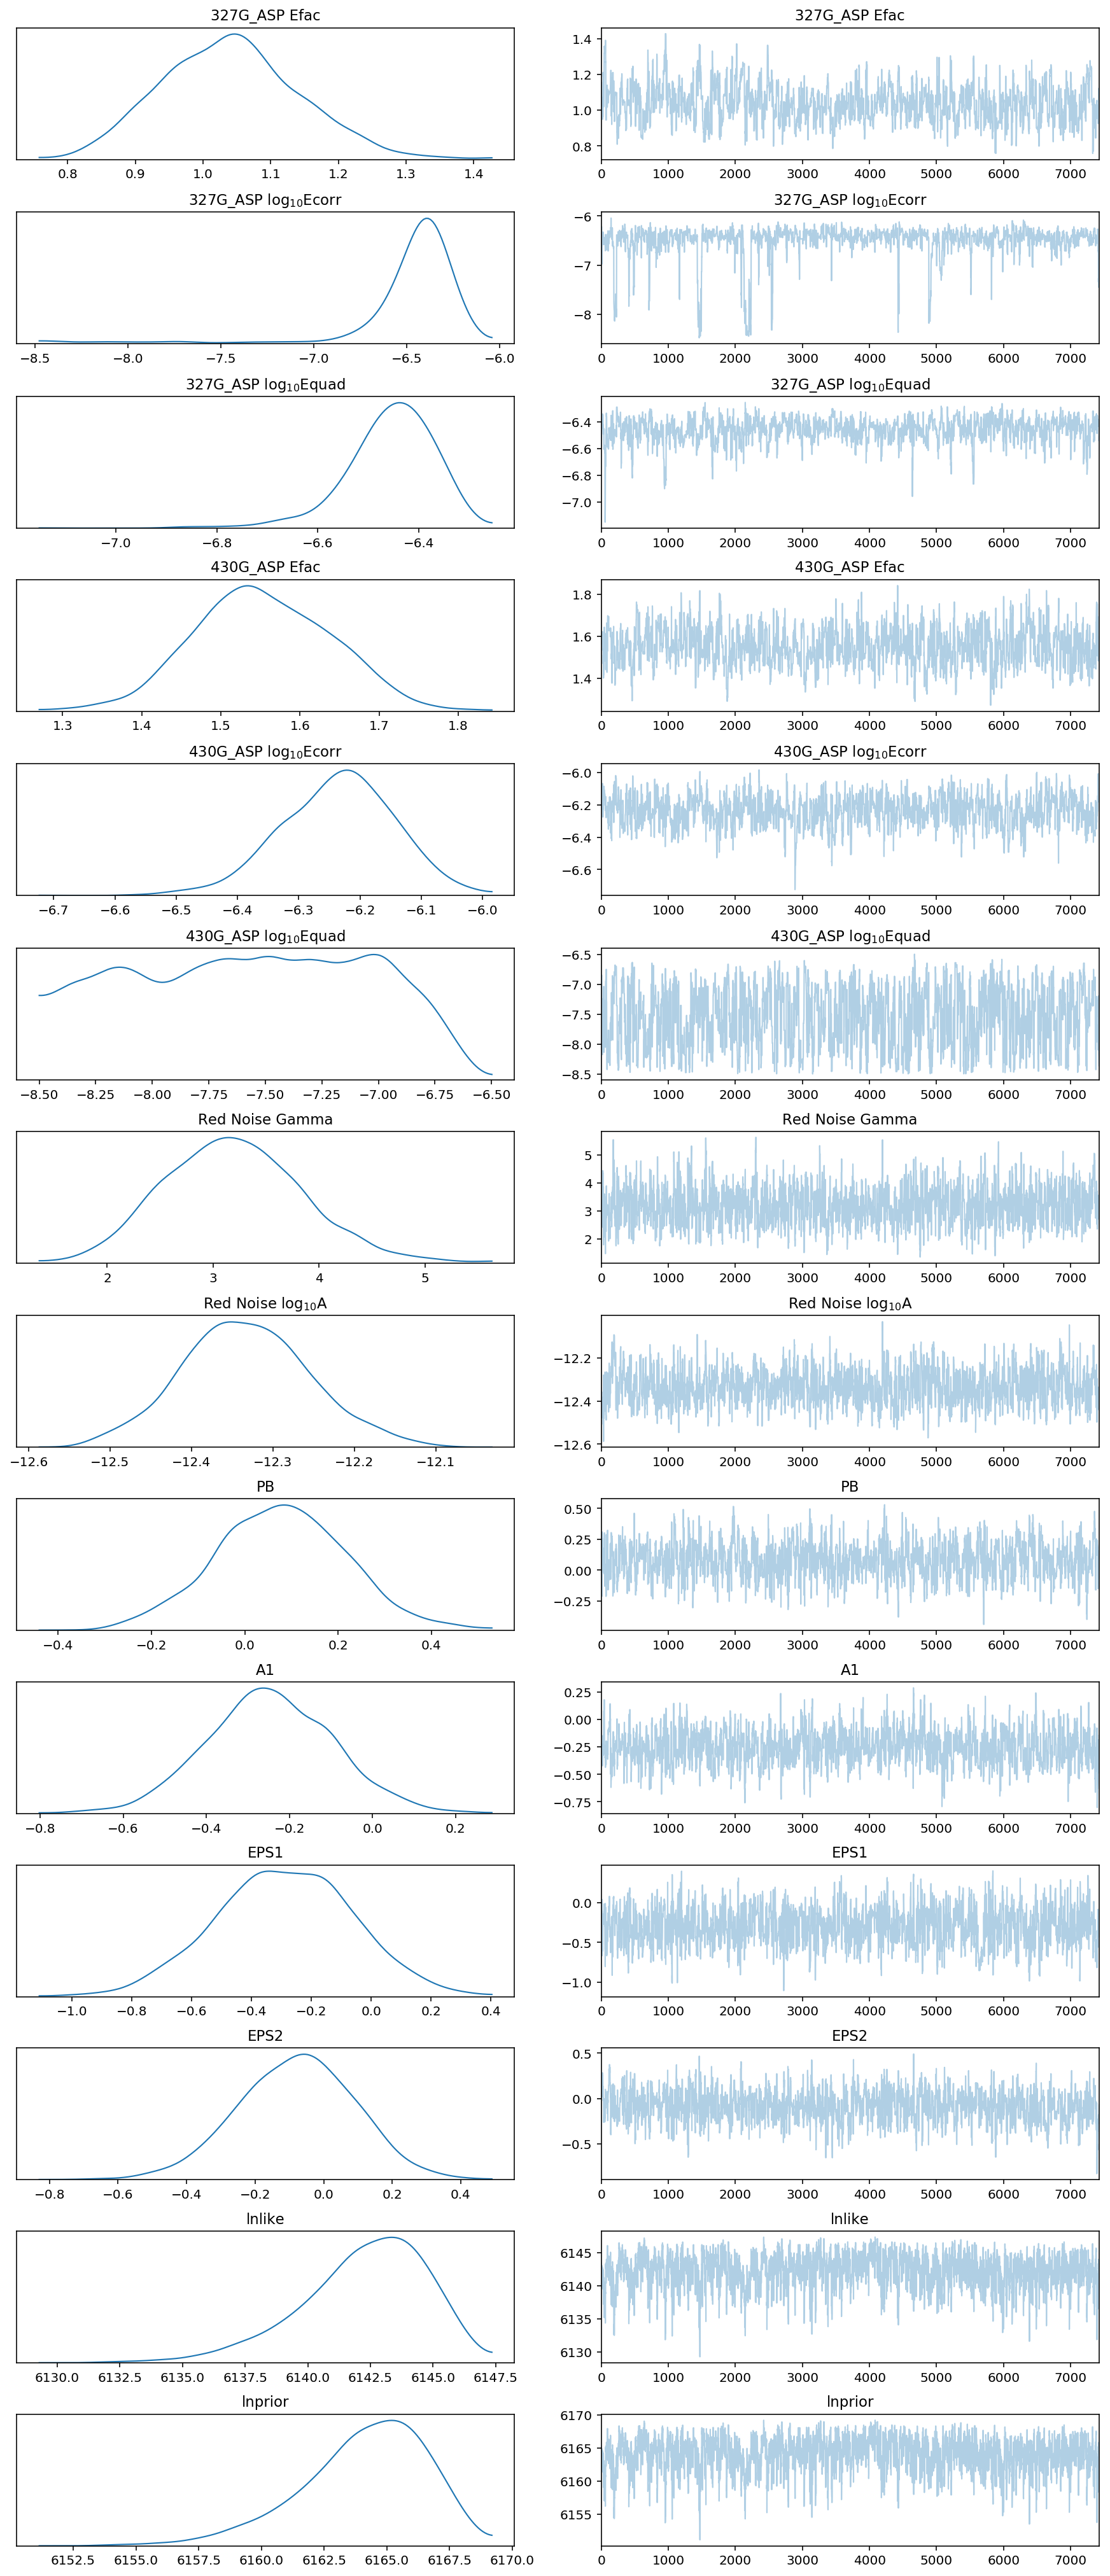

In [7]:
az.plot_trace(az_J2317,var_names=tmparam_list_J2317[:-2]);

This function makes a corner plot for the data, the variable selection is the same as above. You can also change the style with kind: 'kde' are smooth, 'scatter' are individual points in the parameter space, and 'hexbin' bins the data into hex bins

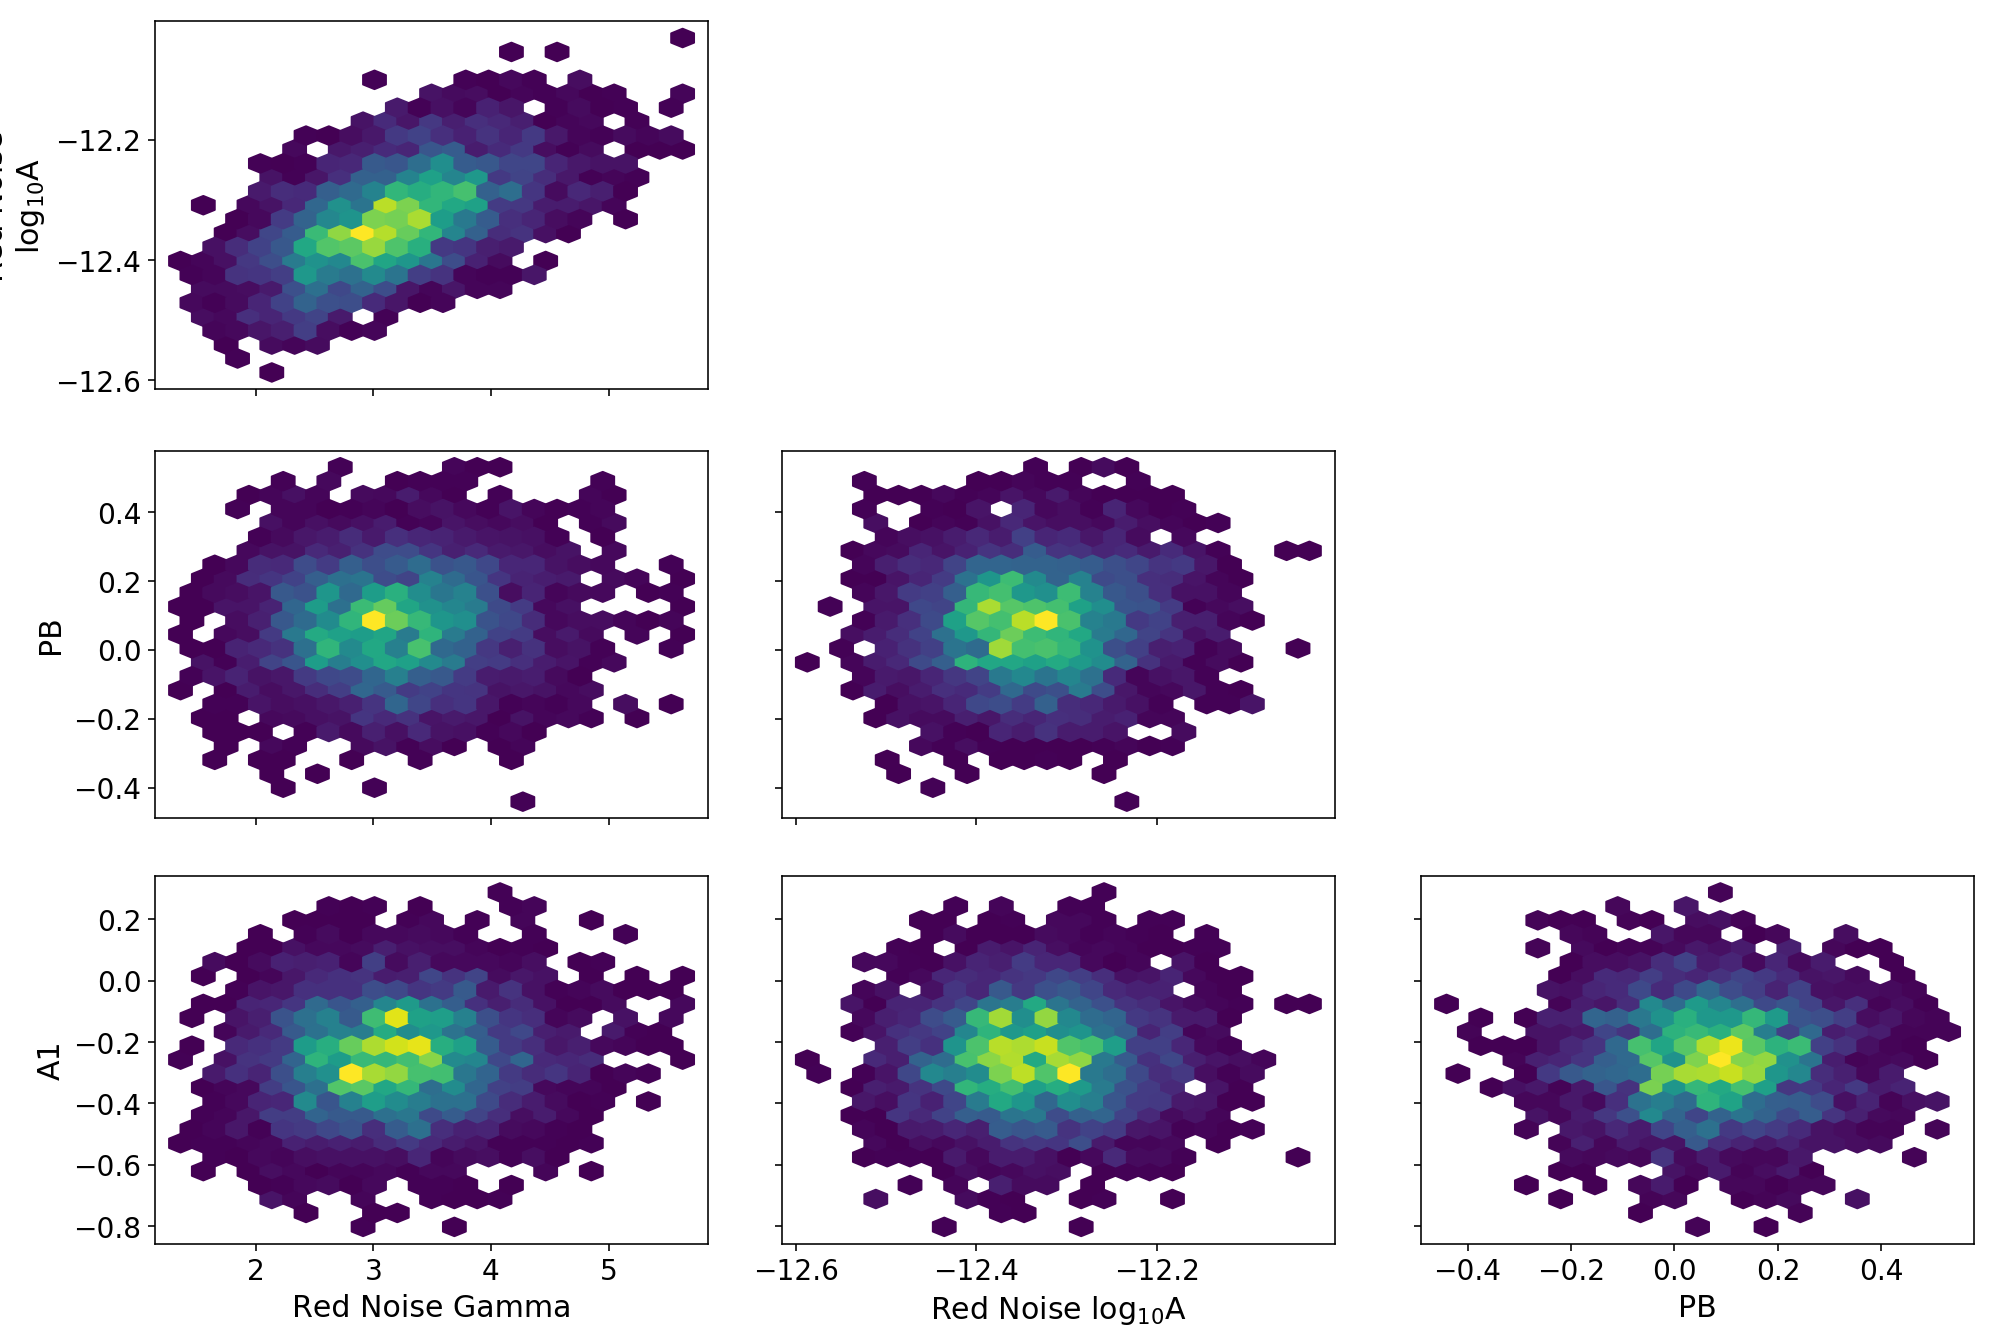

In [8]:
az.plot_pair(az_J2317,var_names=tmparam_list_J2317[6:10],kind='hexbin');

If you don't want to use `la_forge`, you can also load in the chains this way. In addition to the parameter names I defined earlier, you can also just load in the `pars.txt` file in the chain directory

In [9]:
chain_J2317_tm_run_1 = np.loadtxt(chaindir_J2317_tm_run_1 + '/chain_1.txt')
burn_J2317_tm_run_1 = int(0.25 * chain_J2317_tm_run_1.shape[0])
chain_J2317_tm_run_1 = chain_J2317_tm_run_1[burn_J2317_tm_run_1:]

chain_dict_J2317_tm_run_1 = {}
for i,par in enumerate(tmparam_list_J2317):
    chain_dict_J2317_tm_run_1[par] = chain_J2317_tm_run_1[:,i]
az_J2317_from_chains = az.convert_to_inference_data(chain_dict_J2317_tm_run_1)

In [10]:
print(np.shape(chain_J2317_tm_run_1))

(7425, 16)


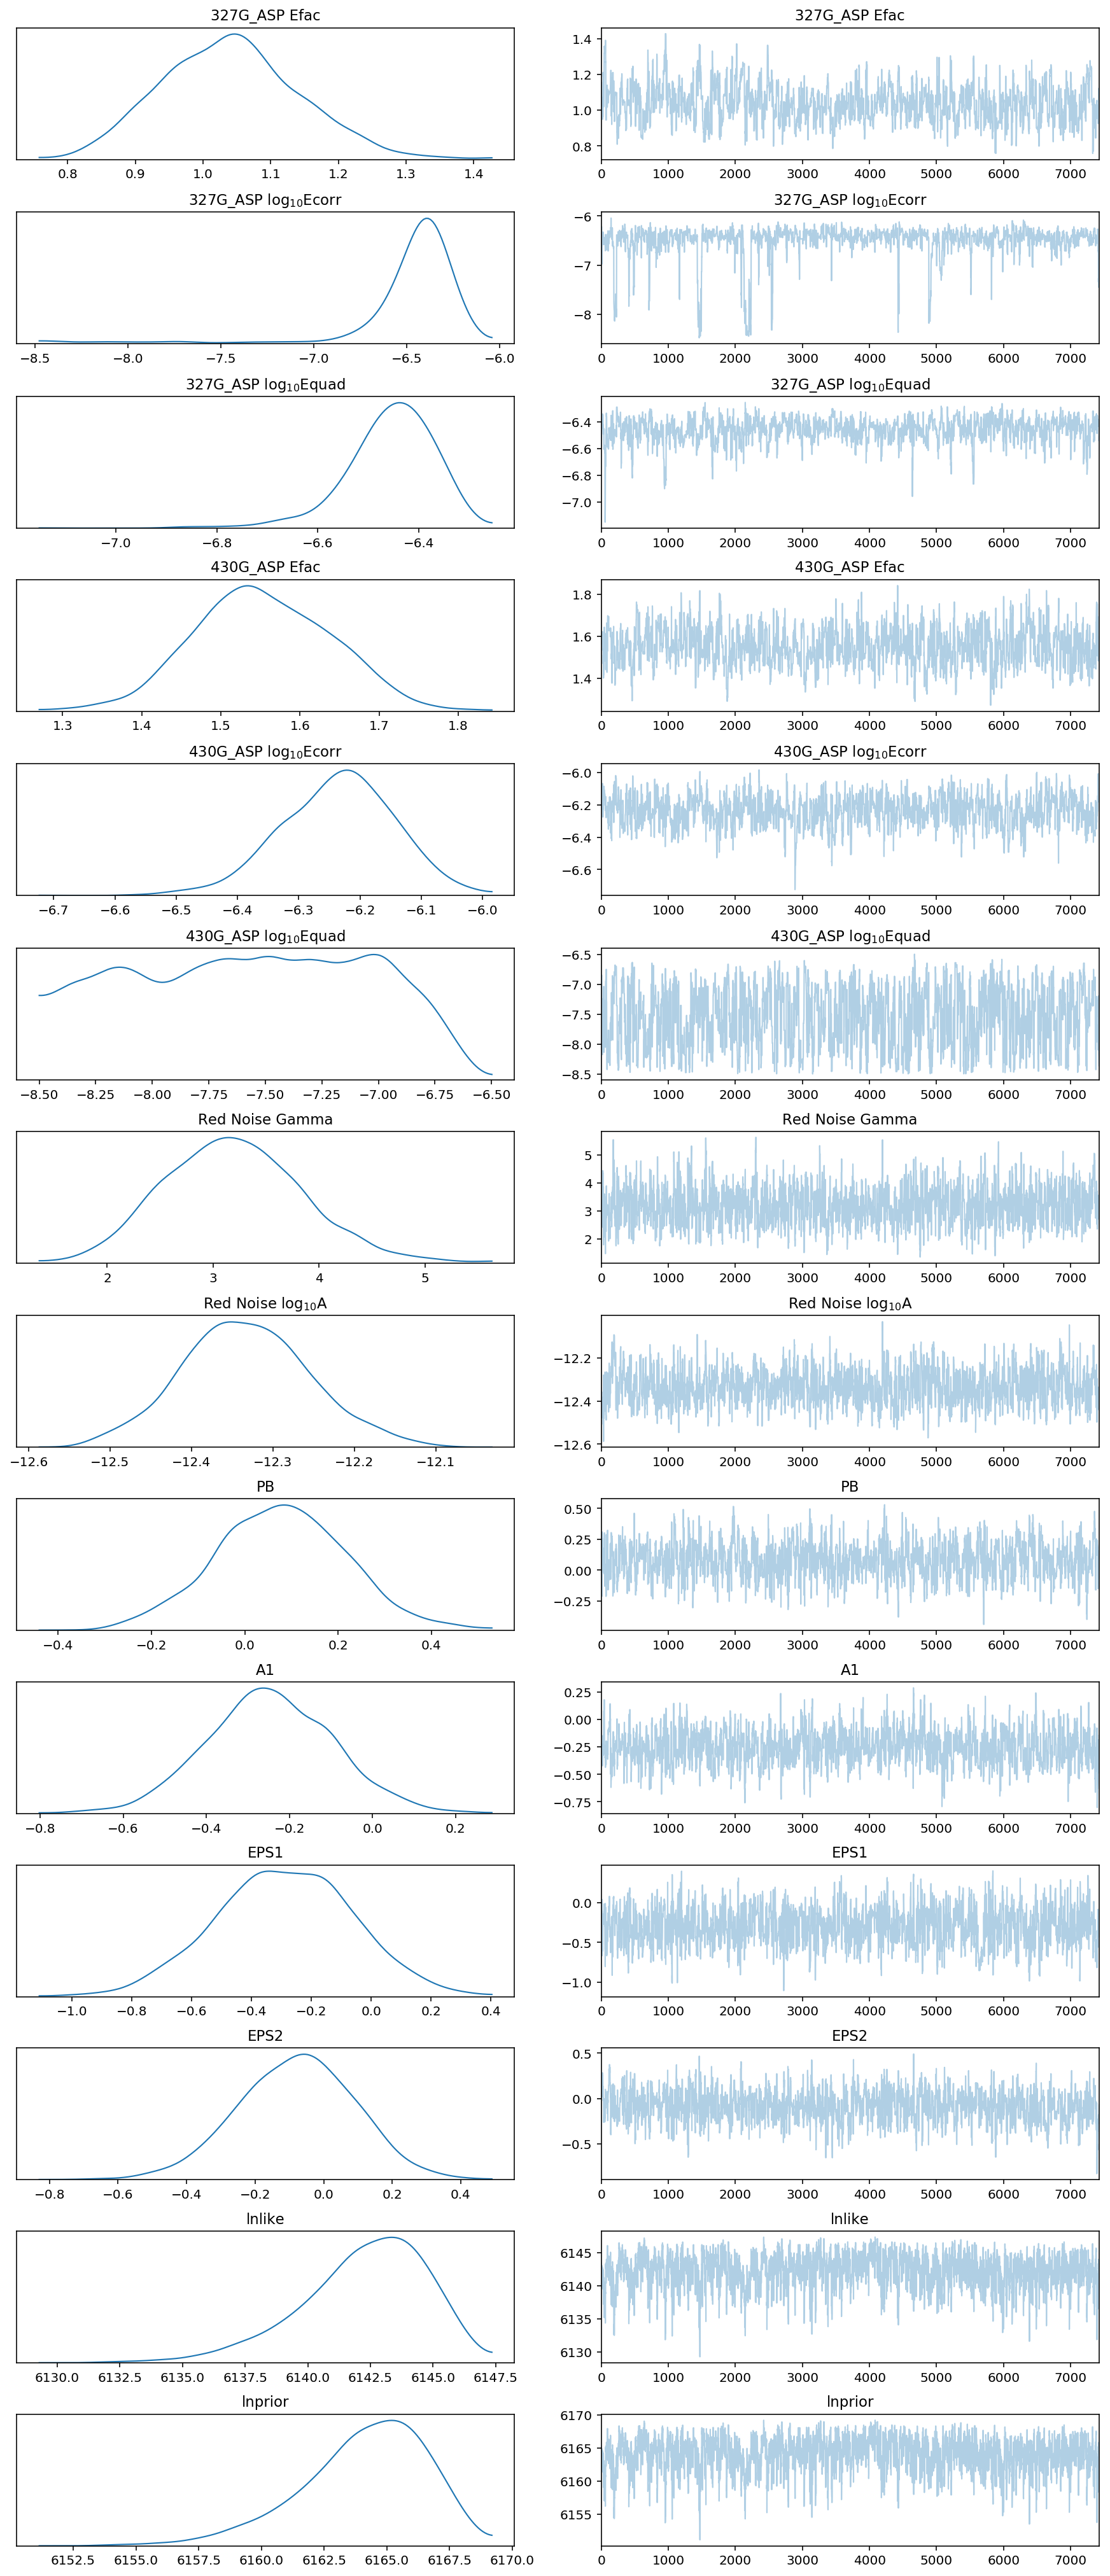

In [11]:
az.plot_trace(az_J2317_from_chains,var_names=tmparam_list_J2317[:-2]);

# Multiple Chains

If you want to compare multiple of the same runs, you will need to load in the other chains and combine them in a different dictionary to load into `ArviZ`.

In [12]:
chaindir_J2317_tm_run_2 = os.getcwd()+'/chains/J2317+1439_red_var_white_var_2'
chaindir_J2317_tm_run_3 = os.getcwd()+'/chains/J2317+1439_red_var_white_var_3'

In [13]:
psr_J2317_tm_run_2 = co.Core(label='psr_J2317_red_var_white_var_2',
                                        chaindir=chaindir_J2317_tm_run_2,
                                        fancy_par_names=tmparam_list_J2317)
psr_J2317_tm_run_3 = co.Core(label='psr_J2317_red_var_white_var_3',
                                        chaindir=chaindir_J2317_tm_run_3,
                                        fancy_par_names=tmparam_list_J2317)

Appending PTMCMCSampler sampling parameters to end of parameter list.
If unwanted please provide a parameter list.
No burn specified. Burn set to 25% of chain length, 2475
You may change the burn length with core.set_burn()
Red noise frequencies must be set before plotting most red noise figures.
Please use core.set_rn_freqs() to set, if needed.
Appending PTMCMCSampler sampling parameters to end of parameter list.
If unwanted please provide a parameter list.
No burn specified. Burn set to 25% of chain length, 2475
You may change the burn length with core.set_burn()
Red noise frequencies must be set before plotting most red noise figures.
Please use core.set_rn_freqs() to set, if needed.


In [14]:
comb_data_dict_J2317_tm_run_1 = {}
for param, param_name in zip(psr_J2317_tm_run_1.params,tmparam_list_J2317):
    comb_data_dict_J2317_tm_run_1[param_name] = np.concatenate(([psr_J2317_tm_run_1.get_param(param)],
                                                                [psr_J2317_tm_run_2.get_param(param)],
                                                                [psr_J2317_tm_run_3.get_param(param)]),
                                                                axis=0)
    
az_comb_J2317 = az.convert_to_inference_data(comb_data_dict_J2317_tm_run_1)

Use this handy function if you would like to know what the parameter space of your chain looks like, it will show you if you loaded in the three separate chains correctly.

In [15]:
print(az_comb_J2317.posterior)

<xarray.Dataset>
Dimensions:                            (chain: 3, draw: 7425)
Coordinates:
  * chain                              (chain) int64 0 1 2
  * draw                               (draw) int64 0 1 2 3 ... 7422 7423 7424
Data variables:
    327G_ASP Efac                      (chain, draw) float64 1.153 ... 1.008
    327G_ASP $\mathrm{log}_{10}$Ecorr  (chain, draw) float64 -6.281 ... -6.467
    327G_ASP $\mathrm{log}_{10}$Equad  (chain, draw) float64 -6.586 ... -6.463
    430G_ASP Efac                      (chain, draw) float64 1.596 ... 1.527
    430G_ASP $\mathrm{log}_{10}$Ecorr  (chain, draw) float64 -6.129 ... -6.244
    430G_ASP $\mathrm{log}_{10}$Equad  (chain, draw) float64 -8.142 ... -7.785
    Red Noise Gamma                    (chain, draw) float64 2.805 ... 2.645
    Red Noise $\mathrm{log}_{10}$A     (chain, draw) float64 -12.34 ... -12.33
    PB                                 (chain, draw) float64 0.04059 ... 0.0209
    A1                                 (chain, d

Since we included multiple chains, `az.summary` can run some of the provided diagnostics.

The less obvious columns correspond to:
*  `hpd` :  Highest posterior density (HPD) of array for a given credible interval
*  `mcse` : Markov Chain Standard Error statistic
*  `ess` :  Estimate of the effective sample size
*  `r_hat` :  Estimate of rank normalized splitR-hat for a set of traces

The `ArviZ` documentation points to https://arxiv.org/abs/1903.08008 for more info on both the `ess` and `r_hat` diagnostics.

In [16]:
az.summary(az_comb_J2317,var_names=tmparam_list_J2317[:-2])

mean     sd    hpd_3%   hpd_97%  \
327G_ASP Efac                         1.038  0.108     0.836     1.240   
327G_ASP $\mathrm{log}_{10}$Ecorr    -6.503  0.340    -7.000    -6.135   
327G_ASP $\mathrm{log}_{10}$Equad    -6.459  0.092    -6.621    -6.297   
430G_ASP Efac                         1.547  0.087     1.391     1.715   
430G_ASP $\mathrm{log}_{10}$Ecorr    -6.237  0.094    -6.408    -6.065   
430G_ASP $\mathrm{log}_{10}$Equad    -7.550  0.517    -8.487    -6.795   
Red Noise Gamma                       3.172  0.636     2.013     4.383   
Red Noise $\mathrm{log}_{10}$A      -12.335  0.078   -12.488   -12.195   
PB                                    0.077  0.142    -0.180     0.350   
A1                                   -0.250  0.155    -0.536     0.048   
EPS1                                 -0.290  0.218    -0.707     0.125   
EPS2                                 -0.081  0.172    -0.405     0.228   
lnlike                             6142.110  2.575  6137.381  6146.493   
lnprior                            6163.953  2.573  6159.232  6168.337   

                                   mcse_mean  mcse_sd  ess_mean  ess_sd  \
327G_ASP Efac                          0.004    0.003     761.0   755.0   
327G_ASP $\mathrm{log}_{10}$Ecorr      0.015    0.011     487.0   477.0   
327G_ASP $\mathrm{log}_{10}$Equad      0.003    0.002     858.0   858.0   
430G_ASP Efac                          0.003    0.002    1107.0  1107.0   
430G_ASP $\mathrm{log}_{10}$Ecorr      0.003    0.002    1350.0  1344.0   
430G_ASP $\mathrm{log}_{10}$Equad      0.015    0.010    1216.0  1216.0   
Red Noise Gamma                        0.014    0.010    2135.0  2042.0   
Red Noise $\mathrm{log}_{10}$A         0.002    0.001    1809.0  1809.0   
PB                                     0.003    0.002    1830.0  1830.0   
A1                                     0.004    0.002    1923.0  1923.0   
EPS1                                   0.005    0.003    2034.0  2034.0   
EPS2                                   0.004    0.003    2086.0  2086.0   
lnlike                                 0.073    0.052    1238.0  1238.0   
lnprior                                0.073    0.052    1237.0  1237.0   

                                   ess_bulk  ess_tail  r_hat  
327G_ASP Efac                         772.0    1217.0   1.00  
327G_ASP $\mathrm{log}_{10}$Ecorr     882.0     516.0   1.01  
327G_ASP $\mathrm{log}_{10}$Equad     870.0    1341.0   1.00  
430G_ASP Efac                        1104.0    1691.0   1.00  
430G_ASP $\mathrm{log}_{10}$Ecorr    1412.0    1547.0   1.00  
430G_ASP $\mathrm{log}_{10}$Equad    1221.0    1958.0   1.00  
Red Noise Gamma                      2184.0    2551.0   1.00  
Red Noise $\mathrm{log}_{10}$A       1837.0    2732.0   1.00  
PB                                   1827.0    2693.0   1.00  
A1                                   1920.0    3018.0   1.00  
EPS1                                 2034.0    2729.0   1.00  
EPS2                                 2103.0    3259.0   1.00  
lnlike                               1270.0    2523.0   1.00  
lnprior                              1269.0    2525.0   1.00

The chains are plotted on top of one another, unless you specify the particular group you wish to examine. For example, doing `coords={'chain':[2]}` looks at the third chain.

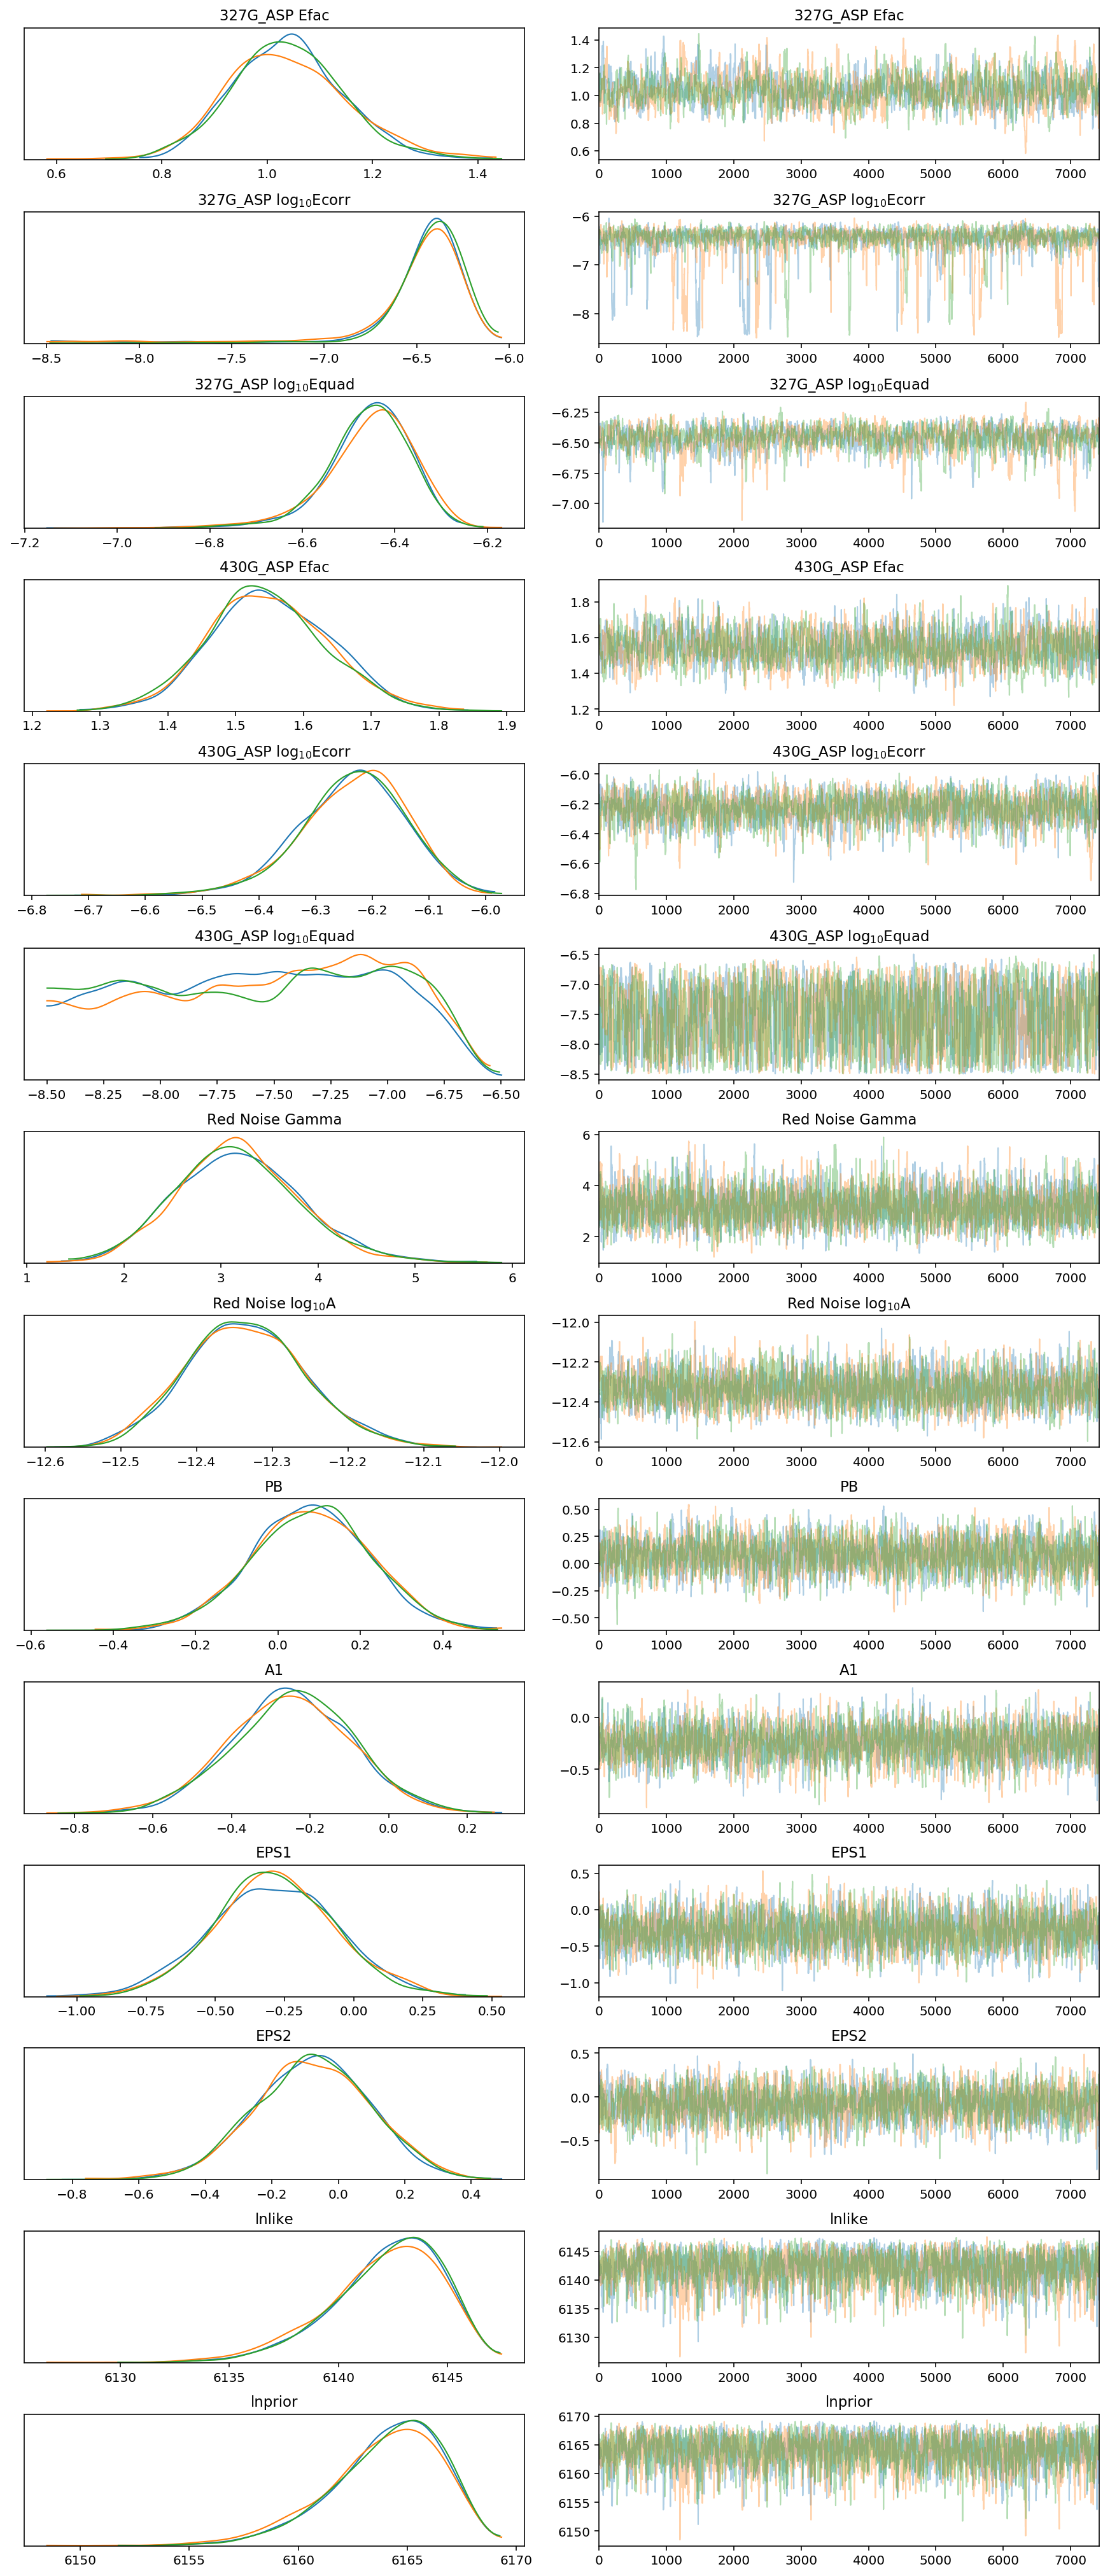

In [17]:
az.plot_trace(az_comb_J2317,
              var_names=tmparam_list_J2317[:-2]);
              #coords={'chain':[2]});

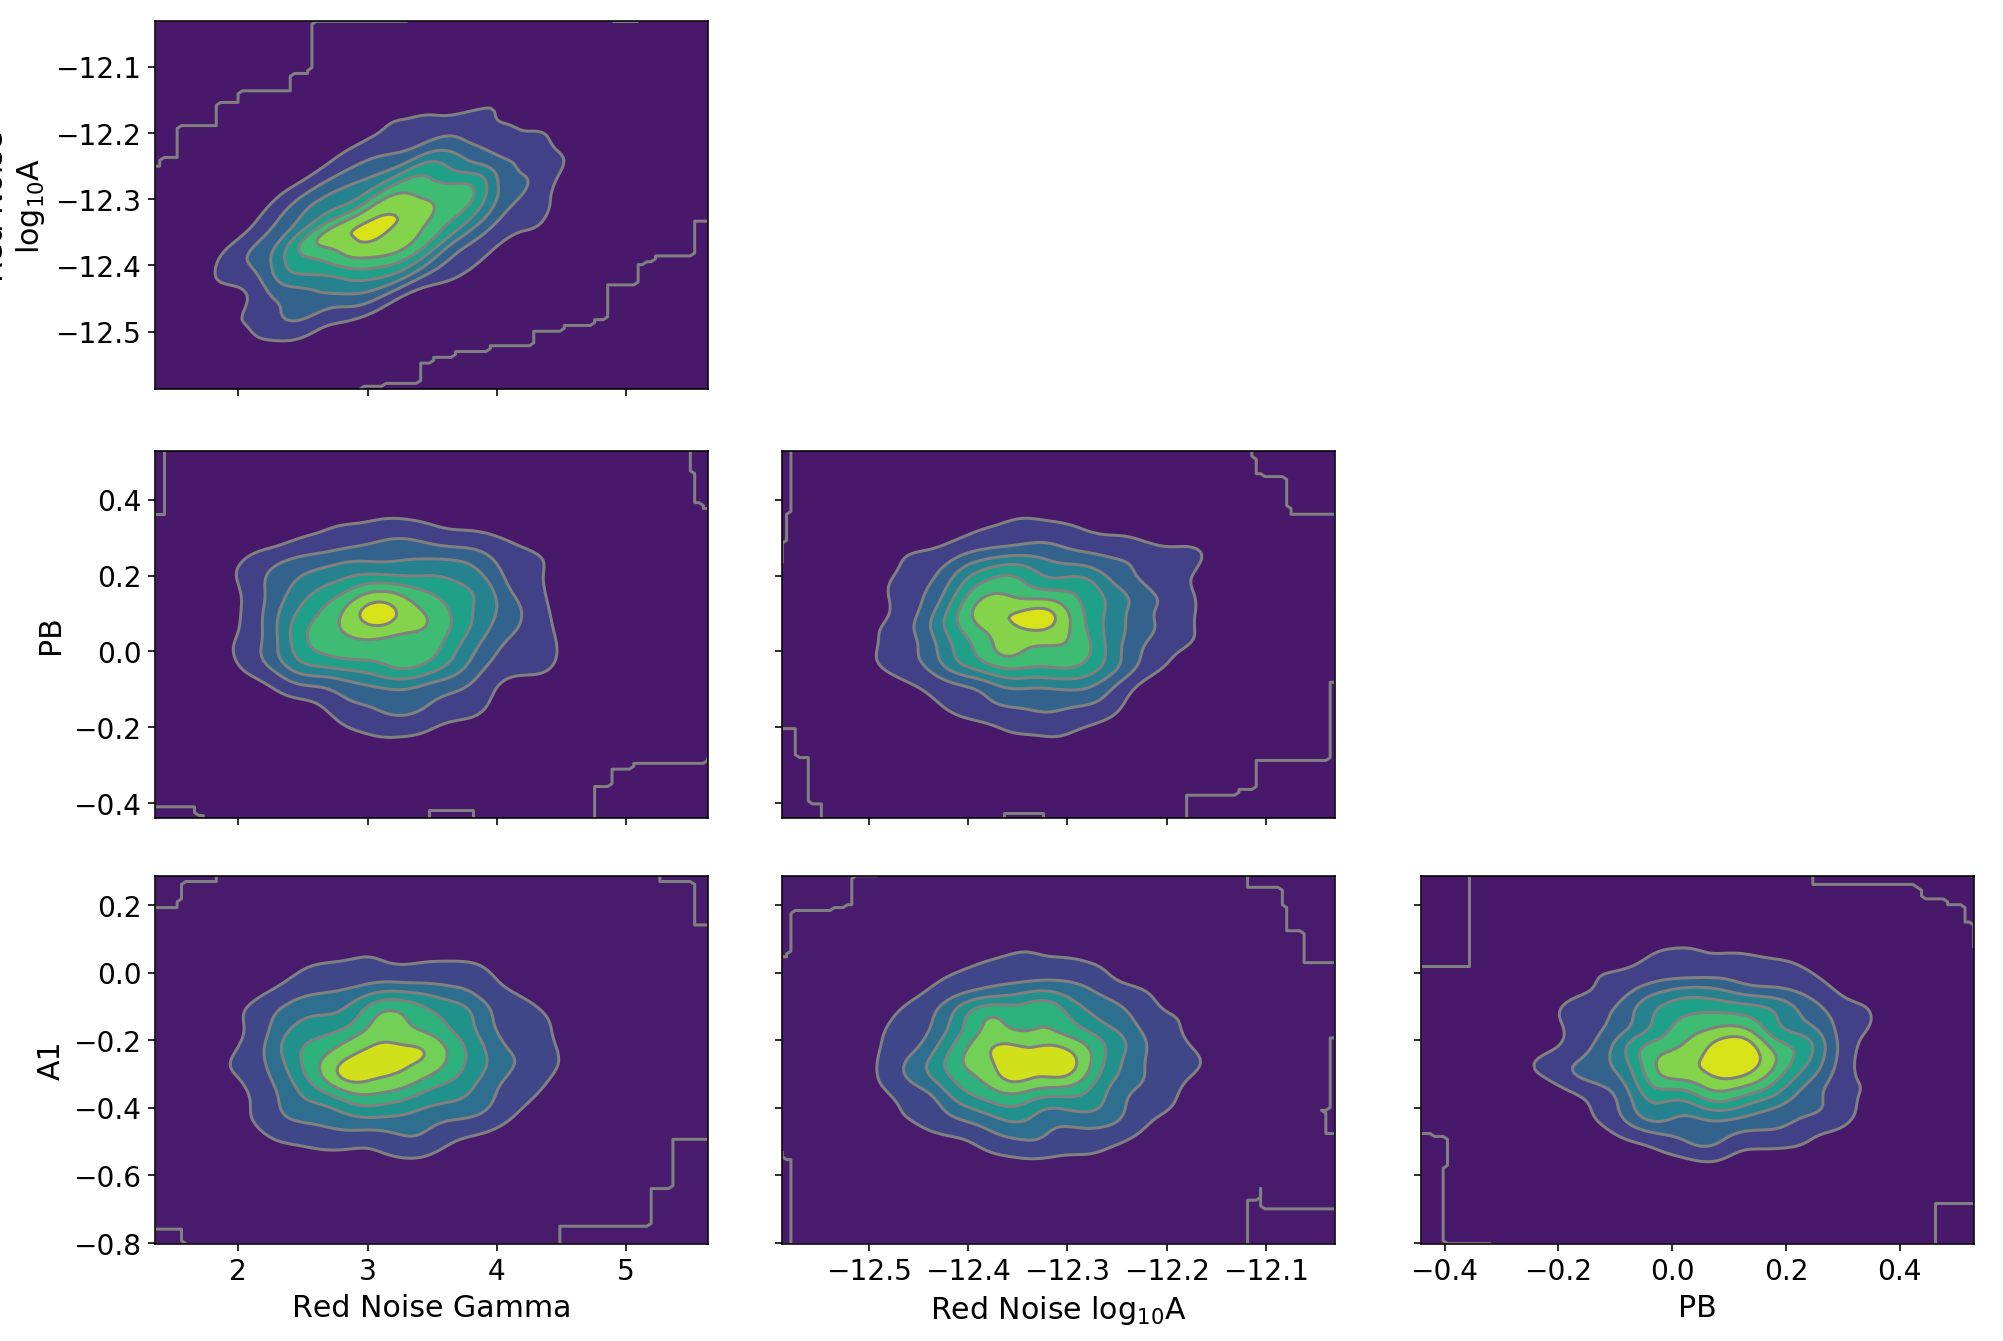

In [18]:
az.plot_pair(az_comb_J2317,
             var_names=tmparam_list_J2317[6:10],
             coords={'chain':[0]},
             kind='kde');